In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 43.22%


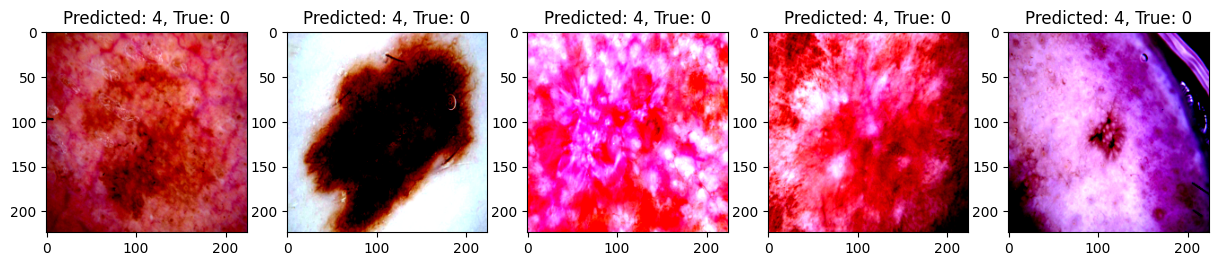

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os

# ============================
# Step 1: Load Pretrained EfficientNet-B0
# ============================
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

# Remove classification head
efficientnet_b0 = torch.nn.Sequential(*(list(efficientnet_b0.children())[:-1]))
efficientnet_b0.eval()

# ============================
# Step 2: Define Transformations
# ============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ============================
# Step 3: Load Dataset
# ============================
train_path = '/content/drive/MyDrive/Skin/Train'
test_path = '/content/drive/MyDrive/Skin/Test'

train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ============================
# Step 4: Feature Extraction
# ============================
def extract_features(dataloader, model, device='cpu'):
    model.to(device)
    features, labels = [], []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = outputs.squeeze(-1).squeeze(-1)  # (B, 1280)
            features.append(outputs.cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

print("Extracting training features...")
train_features, train_labels = extract_features(train_loader, efficientnet_b0)

# ============================
# Step 5: Train SVM
# ============================
print("Training SVM classifier...")
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm.fit(train_features, train_labels)

# ============================
# Step 6: Evaluate Model
# ============================
print("Extracting test features...")
test_features, test_labels = extract_features(test_loader, efficientnet_b0)

predictions = svm.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# ============================
# Step 7: Reports
# ============================
print("\nClassification Report:")
print(classification_report(test_labels, predictions, target_names=test_dataset.classes))

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================
# Step 8: Visualize Predictions
# ============================
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img, label = test_dataset[i]
    ax[i].imshow(img.permute(1, 2, 0).numpy())
    ax[i].set_title(f"Pred: {test_dataset.classes[predictions[i]]}\nTrue: {test_dataset.classes[label]}")
    ax[i].axis('off')
plt.show()

# ============================
# Step 9: Save Model & Metadata (JSON)
# ============================
save_dir = '/content/drive/MyDrive/Skin/Model_Save'
os.makedirs(save_dir, exist_ok=True)

# Save SVM model
svm_path = os.path.join(save_dir, 'efficientnet_svm_model.pkl')
joblib.dump(svm, svm_path)

# Save metadata in JSON
metadata = {
    "model_name": "EfficientNet-B0 + SVM",
    "feature_extractor": "EfficientNet-B0 (pretrained on ImageNet)",
    "svm_kernel": "rbf",
    "accuracy": round(float(accuracy), 4),
    "num_classes": len(train_dataset.classes),
    "classes": train_dataset.classes,
    "feature_vector_size": 1280,
    "train_samples": len(train_dataset),
    "test_samples": len(test_dataset)
}

json_path = os.path.join(save_dir, 'efficientnet_svm_metadata.json')
with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n✅ Model and metadata saved successfully!")
print(f"SVM model: {svm_path}")
print(f"Metadata JSON: {json_path}")
